In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SimpleRNN, Input
from keras.optimizers import Adam
from math import floor
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Spam and Ham Email Classifier
## **CPT 8**
### *Warren de la Cruz*
### *Arvin Ymson*
### *Miguel Singian*

## Exploratory Data Analysis

There are 150 (non-duplicate) rows, labelled either "ham" or "spam".

In [2]:
emails_df = pd.read_csv('email_classification.csv')
emails_df = emails_df.drop_duplicates()
print(emails_df.iloc[0]['email'])
emails_df

Upgrade to our premium plan for exclusive access to premium content and features.


,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham
...,...,...
174,We're pleased to inform you that your refund h...,ham
175,Get rich quick! Invest in our revolutionary ne...,spam
176,Your free trial period is ending soon. Upgrade...,ham
177,Your order is on its way! Track your shipment ...,ham


The dataset is moderately imbalanced: 100 ham and 50 spam. That gives a **proportional chance criterion** benchmark ($1.25 * (\frac{2}{3}^2 + 5\frac{1}{3}^2)$) of 69.4%. A good classifier should be significantly more accurate than that.

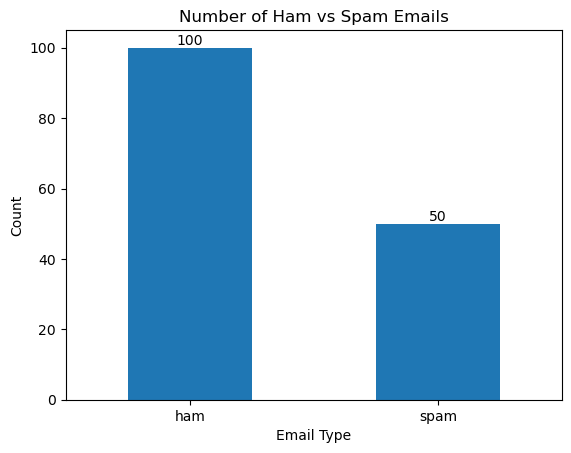

In [3]:
ax = emails_df['label'].value_counts().plot(kind='bar', title='Number of Ham vs Spam Emails')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()


Spam email on average are shorter than ham emails, but also vary more in length. Ham emails have a more consistent length.

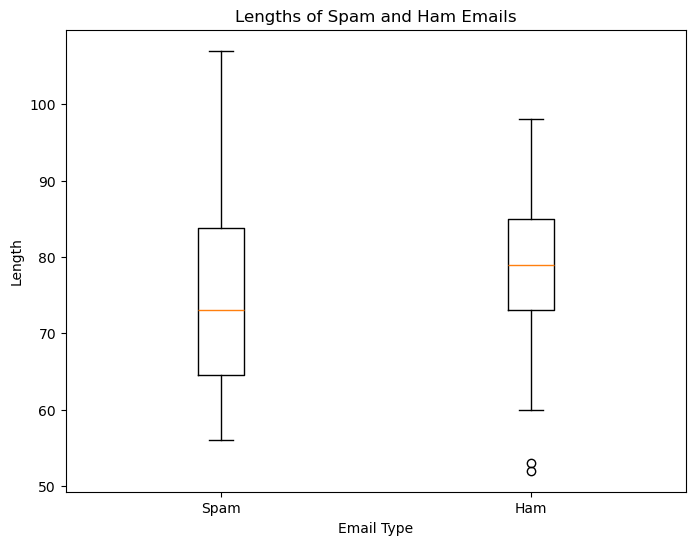

In [4]:
emails_copy = emails_df.copy()

emails_copy['email_length'] = emails_copy['email'].apply(len)

plt.figure(figsize=(8, 6))
ax = plt.boxplot([emails_copy[emails_copy['label'] == 'spam']['email_length'],
                  emails_copy[emails_copy['label'] == 'ham']['email_length']],
                  labels=['Spam', 'Ham'])
plt.title('Lengths of Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Length')
plt.show()

Principal component analysis suggests shows that spam and ham are easily separated by vocabulary alone: the "spam" messages tend to be higher on the vertical principal component.

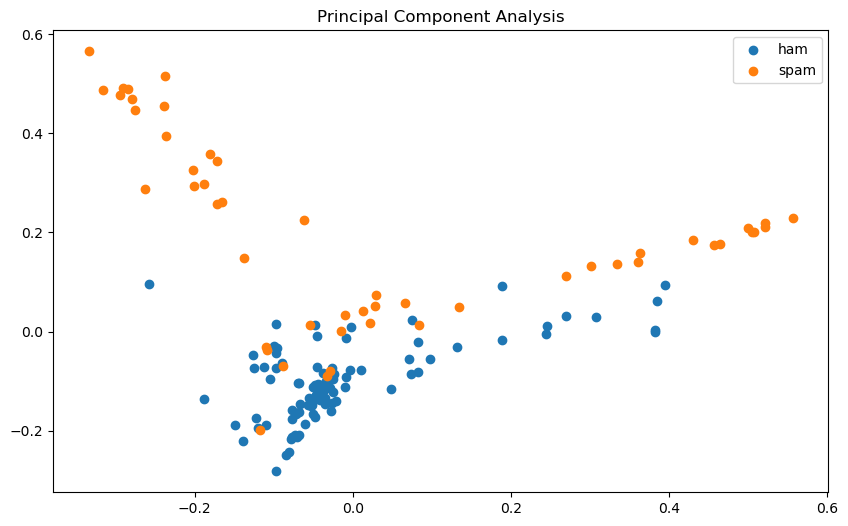

In [5]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

custom_stopwords = list(ENGLISH_STOP_WORDS)

processed_emails = emails_df['email'].apply(lemmatize_text)

tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_emails)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 6))
for label in ['ham', 'spam']:
    indices = emails_df['label'] == label
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label)
plt.title('Principal Component Analysis')
plt.legend()
plt.show()

This is confirmed in the visualization below, which shows the top words in the TF-IDF matrices of spam and ham emails. We see that besides 'ha', the top five spam words are different to the top five ham words. In other words, spam and ham emails have very different vocabulary.

This means that it will be easy to separate spam and ham emails, especially when context is added through RNN/LSTM layers.

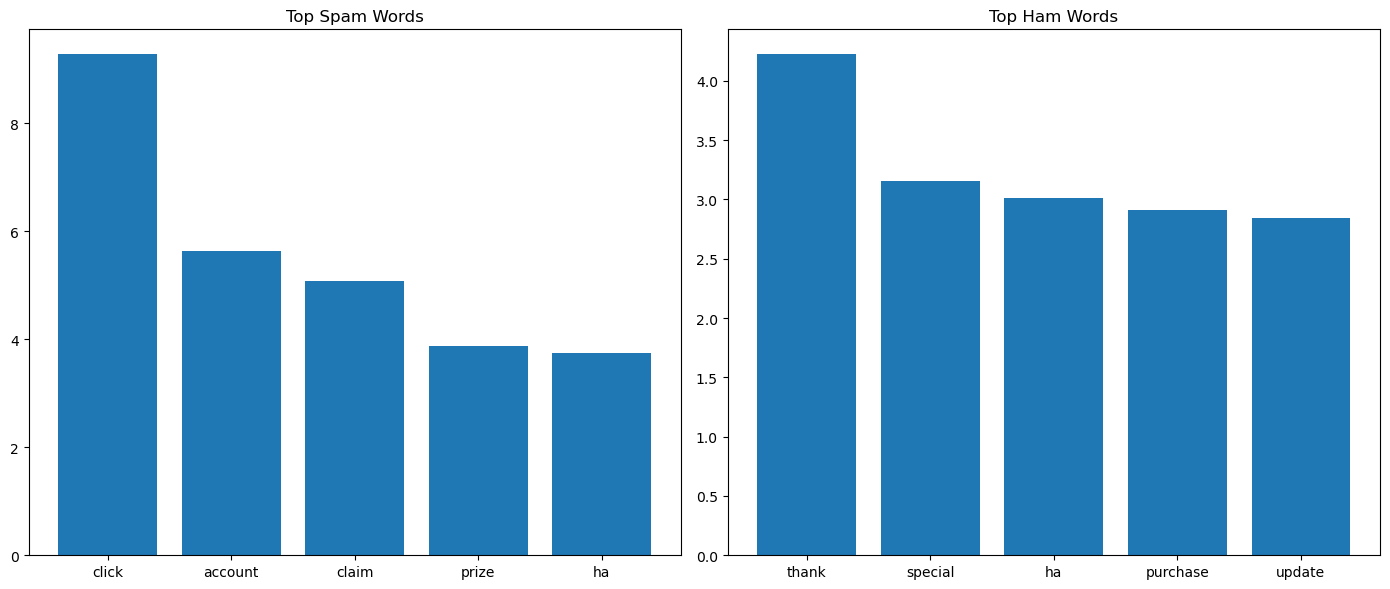

In [6]:
# Identifying top words
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sum_spam = tfidf_matrix[emails_df['label'] == 'spam'].sum(axis=0).A1
tfidf_sum_ham = tfidf_matrix[emails_df['label'] == 'ham'].sum(axis=0).A1

top_spam_words_indices = tfidf_sum_spam.argsort()[-5:][::-1]
top_ham_words_indices = tfidf_sum_ham.argsort()[-5:][::-1]

top_spam_words = [feature_names[i] for i in top_spam_words_indices]
top_ham_words = [feature_names[i] for i in top_ham_words_indices]

# Plot top words side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot top spam words
bars = axes[0].bar(top_spam_words, tfidf_sum_spam[top_spam_words_indices])
axes[0].set_title('Top Spam Words')

# Plot top ham words
bars = axes[1].bar(top_ham_words, tfidf_sum_ham[top_ham_words_indices])
axes[1].set_title('Top Ham Words')


plt.tight_layout()
plt.show()


# Baseline Model

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(emails_df['label'])

X_train, X_test, y_train, y_test = train_test_split(pca_result, y_encoded, test_size=0.15, random_state=42)
def objective(trial):
    # Define parameter ranges
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }

    # Create XGBoost classifier with suggested parameters
    xgb_model = xgb.XGBClassifier(**param_grid)

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create study object and optimize
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters and best accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'n_estimators': 117, 'max_depth': 4, 'learning_rate': 0.120528820805787, 'gamma': 2.6793016434774673e-07}
Best Accuracy: 0.9130434782608695


This baseline XGBoost model, trained on 10 Principal Components, had an accuracy of 91%, significantly beating the proportional chance criteron of 69.4%. The XGBoost model classified the texts solely based on their vocabularies--this may still further be improved with the use of recurrent neural networks that take into account word order.

## Data Preprocessing

1. **Label Encoding**: Convert categorical labels into numerical values using `LabelEncoder()` from scikit-learn.

2. **Tokenization**: Break down each email text into individual words or tokens. This is done using `Tokenizer()` from Keras, which assigns a unique integer to each word in the vocabulary.

3. **Padding Sequences**: Ensure all sequences (lists of integers representing words) are of the same length by padding shorter sequences with zeros. This is done using `pad_sequences()` from Keras.

4. **Splitting Data**: Divide the dataset into training and testing sets. Here, `train_test_split()` from scikit-learn is used with a specified test size and random state for reproducibility.

In [7]:
label_encoder = LabelEncoder()
emails_df['label'] = label_encoder.fit_transform(emails_df['label'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(emails_df['email'])
sequences = tokenizer.texts_to_sequences(emails_df['email'])

max_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_trainval, X_test, y_trainval, y_test = train_test_split(padded_sequences, emails_df['label'], test_size=0.15, random_state=1121)

## Model Creation

Three model architectures were defined:

1. A simple RNN model
2. A simple LSTM model
3. A multilayer LSTM model

The purpose of creating these three was to compare RNN/LSTM models through increasing complexity.

### Early Stopping
- Monitoring validation-loss with a patience of 5 was satisfactory in stopping training when the models were at their best yet still generealizable.

### Hyperparameters

1. **Dropout**: A dropout of 0.5 was chosen for all the models, since it seemed to manage the tendency to overfit with all the models.
2. **Learning Rate**: A *small* learning rate was chosen for the simple RNN since previous iterations of the model seemed to overshoot the weights and cause the validation loss to prematurely increase. This may be due to the vanishing/exploding gradient problem inherent in RNNs. A *larger* learning rate was chosen for the simple and multilayer LSTMs, to get them to converge in under 50 epochs.                                                                                        
                                                                                                                              
                                                                                                                                                                                                                                                                                                                                                               
### Metrics
1. **Accuracy** is good for comparing the model against the baseline PCC.
2. **AUC** is good for evaluating the model's performance on the slightly imbalanced data.

### Architecture
- The full model architectures are shown below.

In [8]:
def create_rnn_model():
    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64),
        SimpleRNN(units=64),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'auc'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)#, start_from_epoch=10)
    
    return model, [early_stopping]


def create_lstm_model():
    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64),
        LSTM(units=64),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0015)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'auc'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)#, start_from_epoch=10)
    
    return model, [early_stopping]


def create_multilayer_lstm_model():
    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64),
        LSTM(units=32, return_sequences=True),
        LSTM(units=32),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0015)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'auc'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)#, start_from_epoch=10)
    
    return model, [early_stopping]

create_rnn_model()[0].summary()
create_lstm_model()[0].summary()
create_multilayer_lstm_model()[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 19, 64)         │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,961 (160.00 KB)

 Trainable params: 40,961 (160.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 19, 64)         │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,729 (256.75 KB)

 Trainable params: 65,729 (256.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 19, 64)         │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 19, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,409 (208.63 KB)

 Trainable params: 53,409 (208.63 KB)

 Non-trainable params: 0 (0.00 B)

## Methodology

We decided to compare the three models using **stratified k-folds cross-validation** in five folds (five 80-20 splits). This is because the dataset of 150 is relatively small on top of being imbalanced, and we therefore wanted to minimize the variability in the train and validation sets. Loss and AUC over the epochs per fold are plotted below.

Fold 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


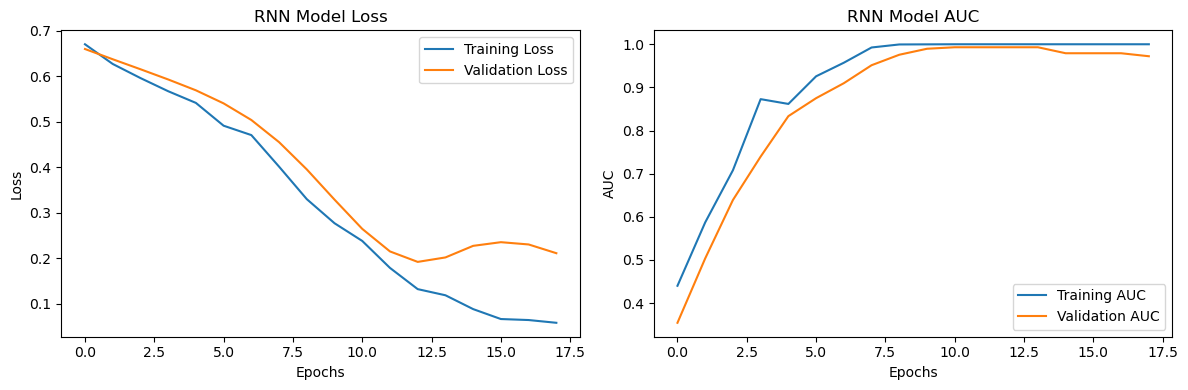

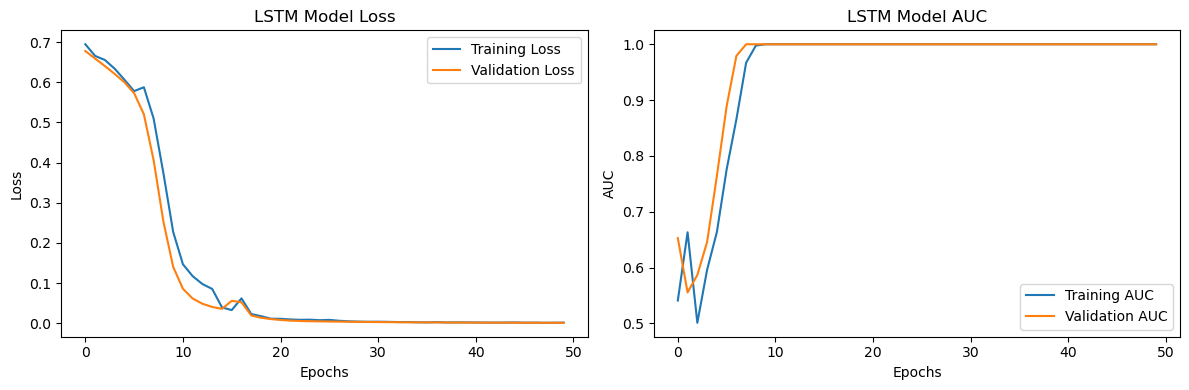

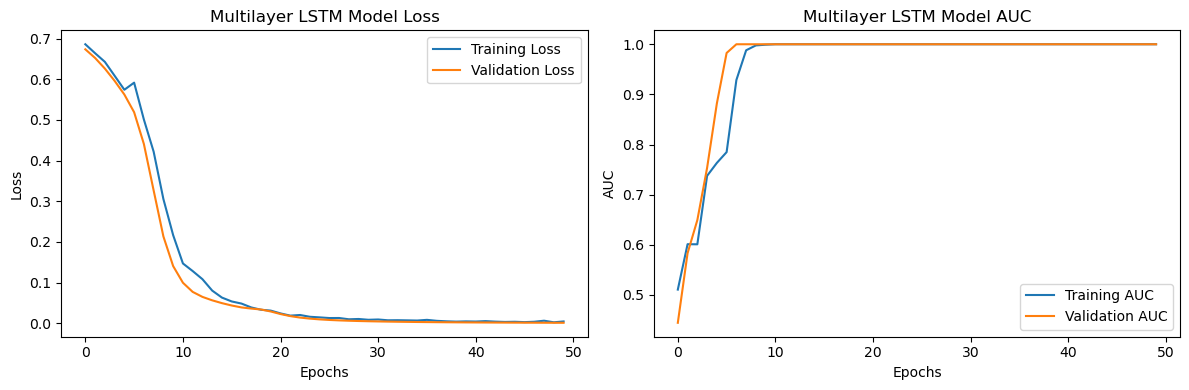

Fold 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


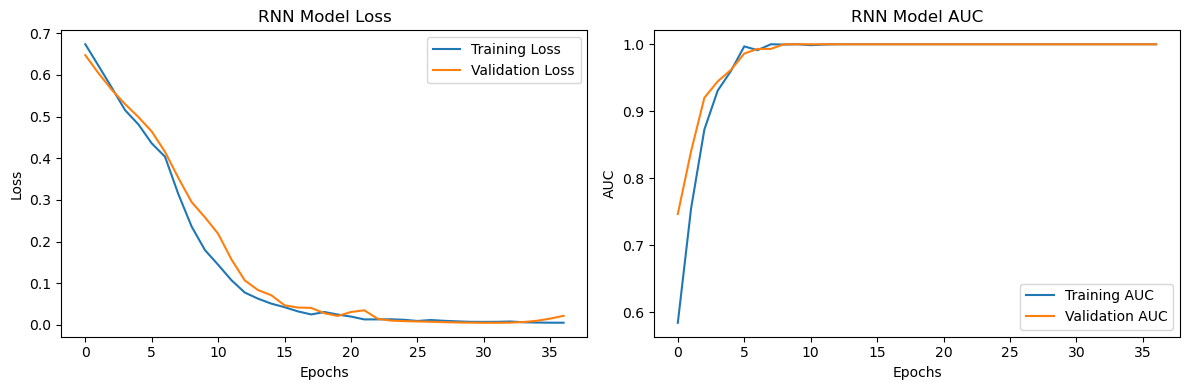

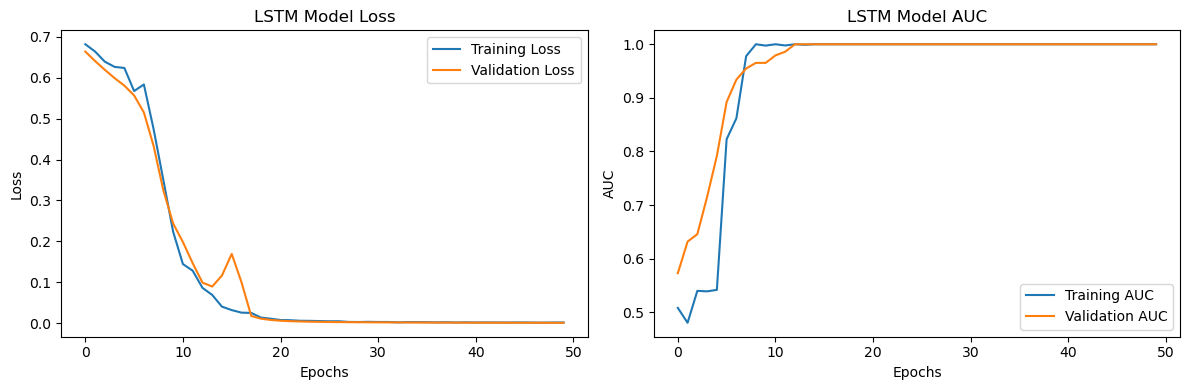

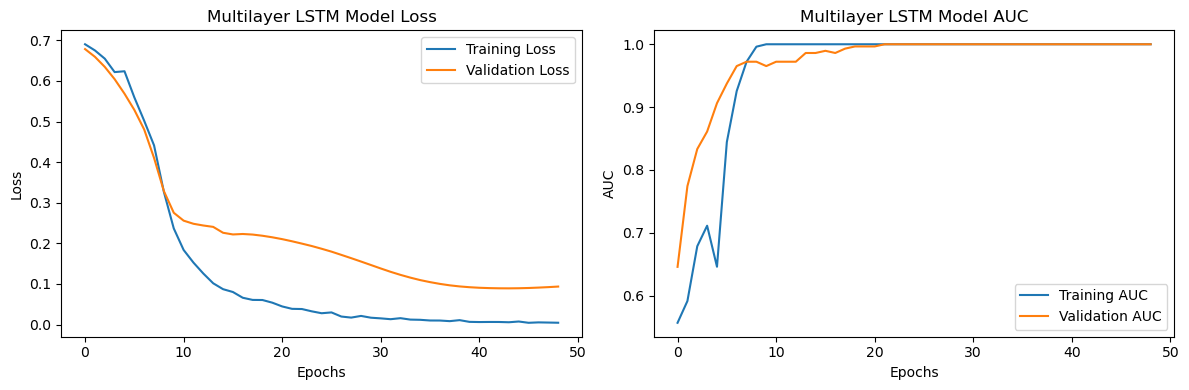

Fold 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


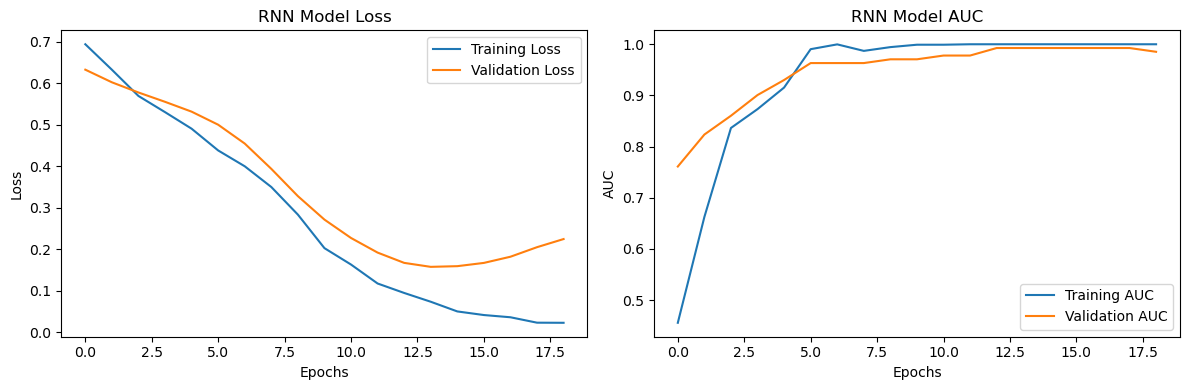

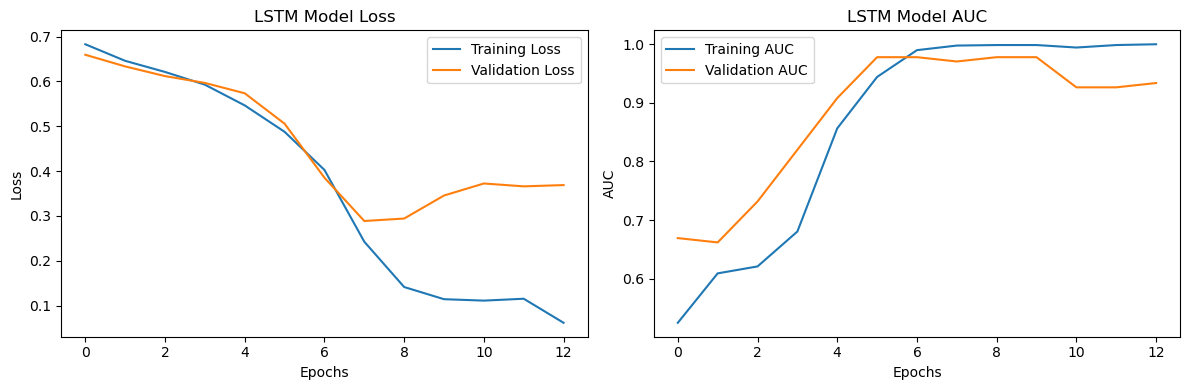

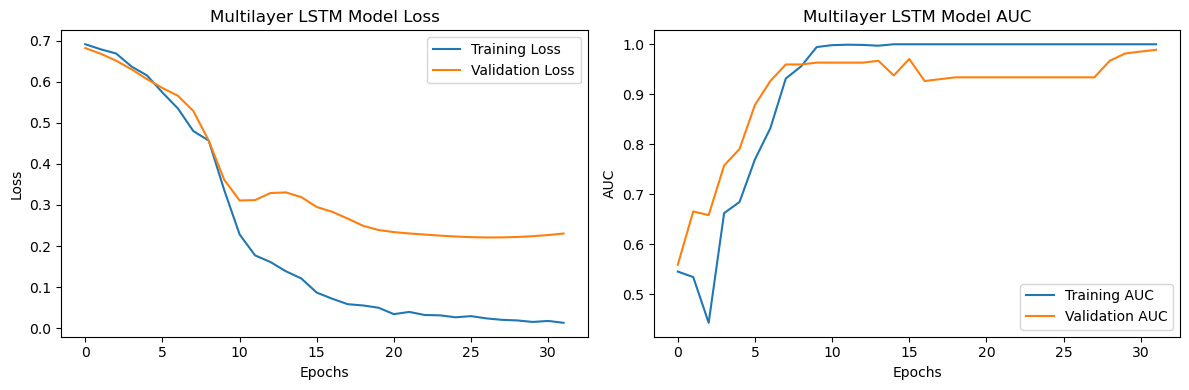

Fold 4:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


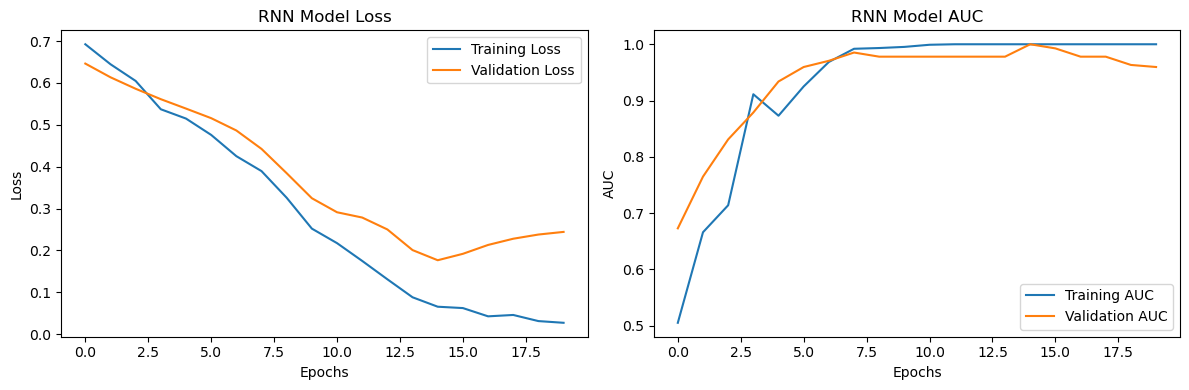

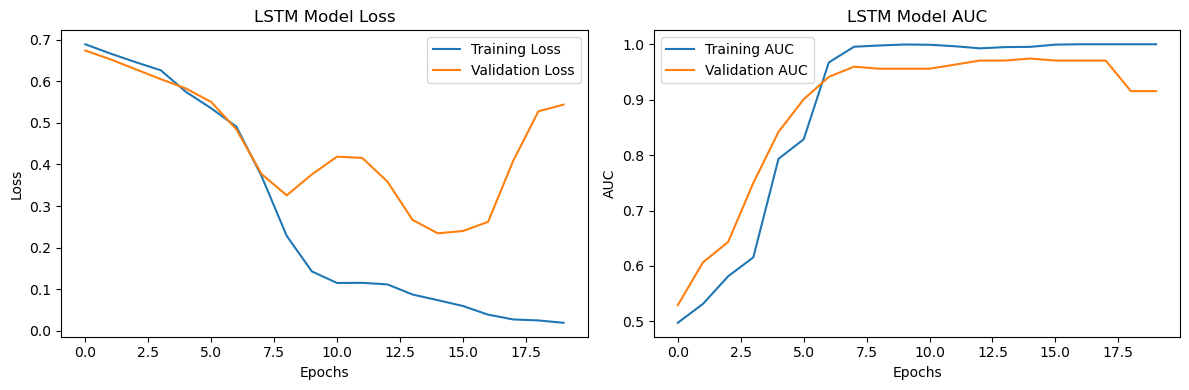

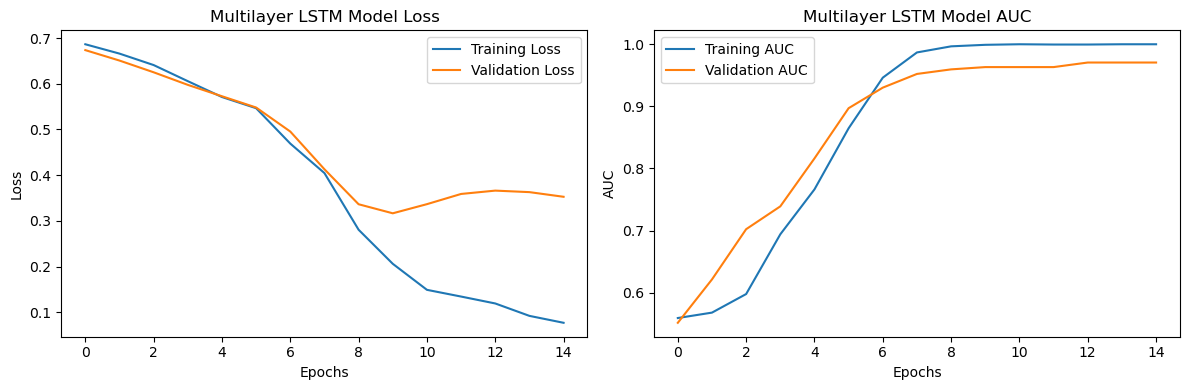

Fold 5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


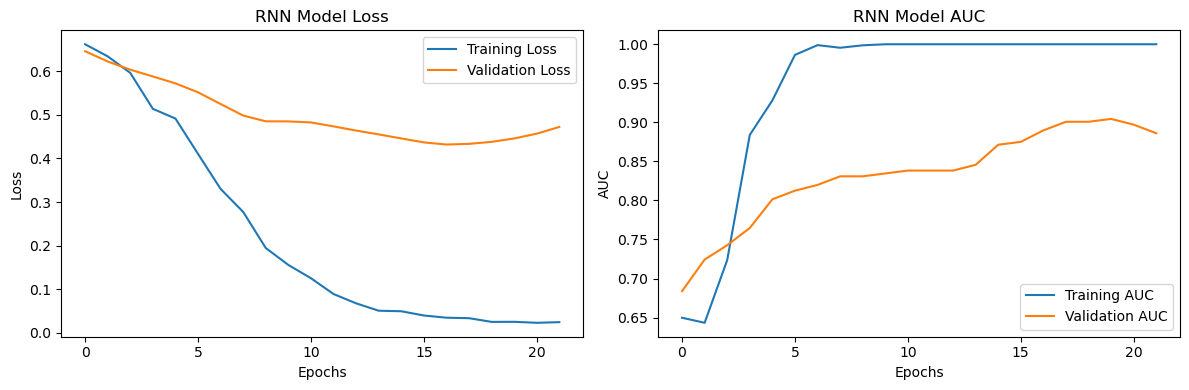

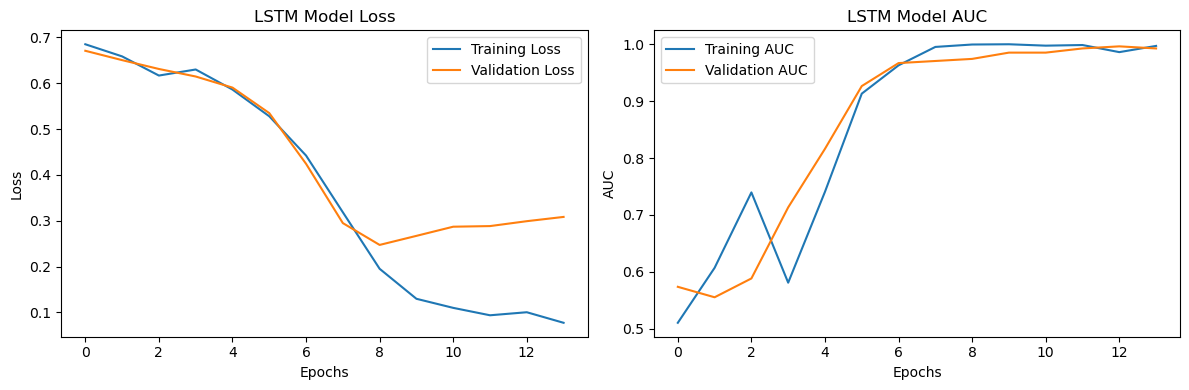

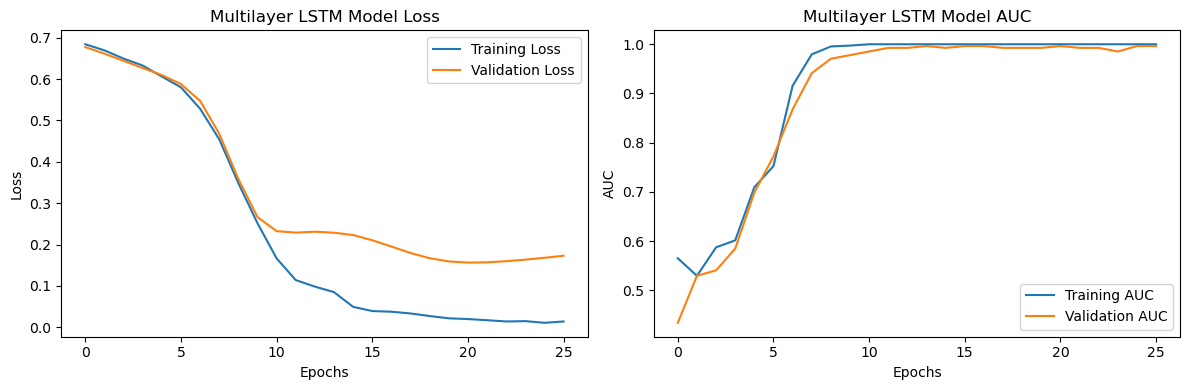

Average RNN AUC: 0.9750816993464053
Average LSTM AUC: 0.9823529411764707
Average Multilayer LSTM AUC: 0.9882352941176471
Average RNN Precision: 0.915
Average LSTM Precision: 0.9054545454545455
Average Multilayer LSTM Precision: 0.9333333333333332
Average RNN Recall: 0.875
Average LSTM Recall: 0.975
Average Multilayer LSTM Recall: 0.925
Average RNN Accuracy: 0.9283076923076923
Average LSTM Accuracy: 0.952
Average Multilayer LSTM Accuracy: 0.9523076923076923
Average number of epochs for RNN: 23.2
Average number of epochs for LSTM: 29.4
Average number of epochs for Multilayer LSTM: 34.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Test set accuracy for RNN: 0.782608695652174
Test set accuracy for LSTM: 0.9130434782608695
Test set accuracy for Multilayer LSTM: 1.0


In [9]:
# Define the number of folds for cross-validation
n_splits = 5
# Initialize lists to store auc for each model
rnn_auc_values = []
lstm_auc_values = []
multilayer_lstm_auc_values = []

# Initialize lists to store precision and recall
rnn_precisions = []
rnn_recalls = []
lstm_precisions = []
lstm_recalls = []
multilayer_lstm_precisions = []
multilayer_lstm_recalls = []

# Initialize variables to store total epochs
total_rnn_epochs = 0
total_lstm_epochs = 0
total_multilayer_lstm_epochs = 0

# Initialize variables to store accuracy
rnn_accuracies = []
lstm_accuracies = []
multilayer_lstm_accuracies = []

# Initialize KFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1121)

# Perform KFold cross-validation
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_trainval, y_trainval), 1):
    print(f'Fold {fold_idx}:')
    X_train_fold, X_val_fold = X_trainval[train_index], X_trainval[val_index]
    y_train_fold, y_val_fold = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    
    # Create RNN model
    rnn_model, callbacks_rnn = create_rnn_model()
    history_rnn = History()
    callbacks_rnn.append(history_rnn)
    rnn_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=callbacks_rnn, verbose=0)

    # Update total epochs for RNN
    total_rnn_epochs += len(history_rnn.epoch)
    
    # Calculate AUC
    rnn_auc = roc_auc_score(y_val_fold, rnn_model.predict(X_val_fold))
    rnn_auc_values.append(rnn_auc)

    # Create LSTM model
    lstm_model, callbacks_lstm = create_lstm_model()
    history_lstm = History()
    callbacks_lstm.append(history_lstm)
    lstm_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=callbacks_lstm, verbose=0)

    # Update total epochs for LSTM
    total_lstm_epochs += len(history_lstm.epoch)
    
    # Calculate AUC
    lstm_auc = roc_auc_score(y_val_fold, lstm_model.predict(X_val_fold))
    lstm_auc_values.append(lstm_auc)

    # Create Multilayer LSTM model
    multilayer_lstm_model, callbacks_multilayer_lstm = create_multilayer_lstm_model()
    history_multilayer_lstm = History()
    callbacks_multilayer_lstm.append(history_multilayer_lstm)
    multilayer_lstm_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=callbacks_multilayer_lstm, verbose=0)

    # Update total epochs for Multilayer LSTM
    total_multilayer_lstm_epochs += len(history_multilayer_lstm.epoch)
    
    # Calculate AUC
    multilayer_lstm_auc = roc_auc_score(y_val_fold, multilayer_lstm_model.predict(X_val_fold))
    multilayer_lstm_auc_values.append(multilayer_lstm_auc)

    # Calculate precision and recall for RNN model
    rnn_precision = precision_score(y_val_fold, np.round(rnn_model.predict(X_val_fold)))
    rnn_recall = recall_score(y_val_fold, np.round(rnn_model.predict(X_val_fold)))
    rnn_precisions.append(rnn_precision)
    rnn_recalls.append(rnn_recall)
    
    # Calculate precision and recall for LSTM model
    lstm_precision = precision_score(y_val_fold, np.round(lstm_model.predict(X_val_fold)))
    lstm_recall = recall_score(y_val_fold, np.round(lstm_model.predict(X_val_fold)))
    lstm_precisions.append(lstm_precision)
    lstm_recalls.append(lstm_recall)
    
    # Calculate precision and recall for Multilayer LSTM model
    multilayer_lstm_precision = precision_score(y_val_fold, np.round(multilayer_lstm_model.predict(X_val_fold)))
    multilayer_lstm_recall = recall_score(y_val_fold, np.round(multilayer_lstm_model.predict(X_val_fold)))
    multilayer_lstm_precisions.append(multilayer_lstm_precision)
    multilayer_lstm_recalls.append(multilayer_lstm_recall)

    # Calculate accuracy for RNN model
    rnn_accuracy = accuracy_score(y_val_fold, np.round(rnn_model.predict(X_val_fold)))
    rnn_accuracies.append(rnn_accuracy)

    # Calculate accuracy for LSTM model
    lstm_accuracy = accuracy_score(y_val_fold, np.round(lstm_model.predict(X_val_fold)))
    lstm_accuracies.append(lstm_accuracy)

    # Calculate accuracy for Multilayer LSTM model
    multilayer_lstm_accuracy = accuracy_score(y_val_fold, np.round(multilayer_lstm_model.predict(X_val_fold)))
    multilayer_lstm_accuracies.append(multilayer_lstm_accuracy)


    # Plot AUC per epoch for each model
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_rnn.history['loss'], label='Training Loss')
    plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
    plt.title('RNN Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_rnn.history['auc'], label='Training AUC')
    plt.plot(history_rnn.history['val_auc'], label='Validation AUC')
    plt.title('RNN Model AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['loss'], label='Training Loss')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['auc'], label='Training AUC')
    plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
    plt.title('LSTM Model AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_multilayer_lstm.history['loss'], label='Training Loss')
    plt.plot(history_multilayer_lstm.history['val_loss'], label='Validation Loss')
    plt.title('Multilayer LSTM Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_multilayer_lstm.history['auc'], label='Training AUC')
    plt.plot(history_multilayer_lstm.history['val_auc'], label='Validation AUC')
    plt.title('Multilayer LSTM Model AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Calculate average AUC for each model
avg_rnn_auc = np.mean(rnn_auc_values)
avg_lstm_auc = np.mean(lstm_auc_values)
avg_multilayer_lstm_auc = np.mean(multilayer_lstm_auc_values)

avg_rnn_precision = np.mean(rnn_precisions)
avg_rnn_recall = np.mean(rnn_recalls)

avg_lstm_precision = np.mean(lstm_precisions)
avg_lstm_recall = np.mean(lstm_recalls)

avg_multilayer_lstm_precision = np.mean(multilayer_lstm_precisions)
avg_multilayer_lstm_recall = np.mean(multilayer_lstm_recalls)

# Calculate average accuracy for each model
avg_rnn_accuracy = np.mean(rnn_accuracies)
avg_lstm_accuracy = np.mean(lstm_accuracies)
avg_multilayer_lstm_accuracy = np.mean(multilayer_lstm_accuracies)

print("Average RNN AUC:", avg_rnn_auc)
print("Average LSTM AUC:", avg_lstm_auc)
print("Average Multilayer LSTM AUC:", avg_multilayer_lstm_auc)

print("Average RNN Precision:", avg_rnn_precision)
print("Average LSTM Precision:", avg_lstm_precision)
print("Average Multilayer LSTM Precision:", avg_multilayer_lstm_precision)

print("Average RNN Recall:", avg_rnn_recall)
print("Average LSTM Recall:", avg_lstm_recall)
print("Average Multilayer LSTM Recall:", avg_multilayer_lstm_recall)

print("Average RNN Accuracy:", avg_rnn_accuracy)
print("Average LSTM Accuracy:", avg_lstm_accuracy)
print("Average Multilayer LSTM Accuracy:", avg_multilayer_lstm_accuracy)


avg_rnn_epochs = total_rnn_epochs / n_splits
avg_lstm_epochs = total_lstm_epochs / n_splits
avg_multilayer_lstm_epochs = total_multilayer_lstm_epochs / n_splits

print("Average number of epochs for RNN:", avg_rnn_epochs)
print("Average number of epochs for LSTM:", avg_lstm_epochs)
print("Average number of epochs for Multilayer LSTM:", avg_multilayer_lstm_epochs)

# Evaluate with the test set
rnn_test_accuracy = accuracy_score(y_test, np.round(rnn_model.predict(X_test)))
lstm_test_accuracy = accuracy_score(y_test, np.round(lstm_model.predict(X_test)))
multilayer_lstm_test_accuracy = accuracy_score(y_test, np.round(multilayer_lstm_model.predict(X_test)))

print("Test set accuracy for RNN:", rnn_test_accuracy)
print("Test set accuracy for LSTM:", lstm_test_accuracy)
print("Test set accuracy for Multilayer LSTM:", multilayer_lstm_test_accuracy)


## Results



As expected, `Multilayer LSTM` beat the other two models both by AUC and accuracy (though we note that it had slightly lower recall). The results themselves were actually very close, and there is very little difference in the performance of the Simple vs Multilayer LSTM. This could indicate that the extra depth given by multiple layers is not very needed.

\*Note that the `Test Set Accuracy` shown below is the accuracy of the model from the **last fold**, and not the final test accuracy.

In [10]:
results_data = {
    "Model": ["Simple RNN", "Simple LSTM", "Multilayer LSTM"],
    "Average AUC": [avg_rnn_auc, avg_lstm_auc, avg_multilayer_lstm_auc],
    "Average Precision": [avg_rnn_precision, avg_lstm_precision, avg_multilayer_lstm_precision],
    "Average Recall": [avg_rnn_recall, avg_lstm_recall, avg_multilayer_lstm_recall],
    "Average Accuracy": [avg_rnn_accuracy, avg_lstm_accuracy, avg_multilayer_lstm_accuracy],
    "Average Epochs": [avg_rnn_epochs, avg_lstm_epochs, avg_multilayer_lstm_epochs],
    "Test Set Accuracy": [rnn_test_accuracy, lstm_test_accuracy, multilayer_lstm_test_accuracy]
}

results_df = pd.DataFrame(results_data)
results_df

,Model,Average AUC,Average Precision,Average Recall,Average Accuracy,Average Epochs,Test Set Accuracy
0,Simple RNN,0.975082,0.915000,0.875,0.928308,23.2,0.782609
1,Simple LSTM,0.982353,0.905455,0.975,0.952000,29.4,0.913043
2,Multilayer LSTM,0.988235,0.933333,0.925,0.952308,34.4,1.000000


## Final Model

Due to having the best k-folds `AUC` and `Accuracy` we chose to use the Multilayer LSTM architecture in our final model.

To create the final model, we trained the same architecture on the whole trainval set in the average number of epochs as early stopped during k-folds testing, and tested it on the never-before-seem test set. It achieved a 100% accuracy on the test set. This is a good result, though it may also be a statistical anomaly considering the small size of the test set.

In [11]:
multilayer_lstm_model, _ = create_multilayer_lstm_model()
multilayer_lstm_model.fit(X_trainval, y_trainval, epochs=floor(avg_multilayer_lstm_epochs), batch_size=64)

multilayer_lstm_test_accuracy = accuracy_score(y_test, np.round(multilayer_lstm_model.predict(X_test)))

y_pred = multilayer_lstm_model.predict(X_test)

multilayer_lstm_test_accuracy = accuracy_score(y_test, np.round(y_pred))
print("Test set accuracy for Retrained Multilayer LSTM:", multilayer_lstm_test_accuracy)

multilayer_lstm_auc = roc_auc_score(y_test, y_pred)
print("AUC for Retrained Multilayer LSTM:", multilayer_lstm_auc)

Epoch 1/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6179 - auc: 0.6104 - loss: 0.6883
Epoch 2/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6650 - auc: 0.6179 - loss: 0.6694
Epoch 3/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6807 - auc: 0.6753 - loss: 0.6453
Epoch 4/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6859 - auc: 0.7216 - loss: 0.6121
Epoch 5/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7067 - auc: 0.7709 - loss: 0.5697
Epoch 6/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6911 - auc: 0.8707 - loss: 0.5288
Epoch 7/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6807 - auc: 0.9417 - loss: 0.4876
Epoch 8/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7384 - auc: 0.9772 - loss: 0.3914
Epoch 9/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9581 - auc: 0.9994 - loss: 0.2494
Epoch 10/34
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9738 - auc: 0.9993 - loss: 0.1797
Epoch 11/34
2/2 ━━━━━━━━━━━━━